In [2]:
import os
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_percentage_error

from src.util import *
from src.dense import DenseClassifier, DenseNN
from src.lstm import LSTM
from src.cnn import CNN1D, CNNLSTM

In [3]:
ROOT = os.getcwd()
MODELS = os.path.join(ROOT, 'models')
METRICS = os.path.join(ROOT, 'metrics')
DATA = os.path.join(ROOT, 'dataset')
FIGURES = os.path.join(ROOT, 'figures')

In [4]:
# Detectar si hay GPU disponible y configurar el dispositivo
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## Build Dataset

In [5]:
# Read the CSV file from the dataset folder
file_path = os.path.join(DATA, 'TrafficTwoMonth.csv')
df = pd.read_csv(file_path)

# Create datetime column
df = create_datetime_column(df)
df.drop(['Time', 'Date', 'Day of the week'], axis=1, inplace=True)

# Modelos de redes neuronales

## Preparación del Dataset

Para aplicar modelos de redes neuronales a nuestra serie temporal de tráfico vehicular, primero debemos preparar adecuadamente los datos. El proceso incluye:

### División del Dataset
- **Train**: 4761 muestras (80.0% del total)
- **Validation**: 691 muestras (10.0% del total) 
- **Test**: 692 muestras (10.0% del total)

### Creación de Ventanas Deslizantes
Se crean ventanas secuenciales con:
- **Input**: 96 pasos temporales (equivalente a 24 horas)
- **Label**: 1 paso temporal a predecir

Esto resulta en:
- **Train**: 4665 ventanas
- **Validation**: 595 ventanas  
- **Test**: 596 ventanas

### Configuración de DataLoaders
Los datos se organizan en lotes (batches) para el entrenamiento:
- **Batch size**: 16 muestras
- **Train**: 292 batches (4665 muestras)
- **Validation**: 38 batches (595 muestras)
- **Test**: 38 batches (596 muestras)

Configuración adicional:
- Shuffle activado solo para datos de entrenamiento
- 0 workers para el procesamiento




División de datos:
Train: 4761 muestras (80.0%)
Validation: 691 muestras (10.0%)
Test: 692 muestras (10.0%)

Ventanas creadas:
Train: 4665 ventanas
Validation: 595 ventanas
Test: 596 ventanas

Tamaño de cada ventana:
Input: 96 pasos
Label: 1 pasos

Dataloaders creados:
Train: 4665 muestras, 146 batches
Validation: 595 muestras, 19 batches
Test: 596 muestras, 19 batches

Configuración:
Batch size: 32
Workers: 0
Shuffle: True (train), False (val/test)


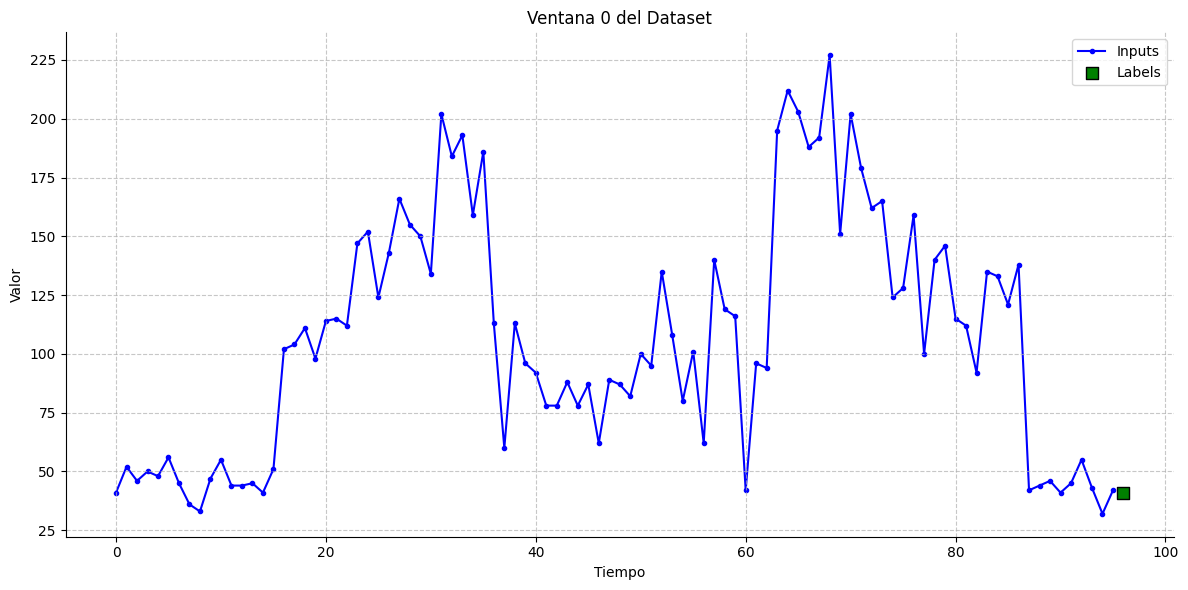

In [11]:
data = df['Total'].to_numpy()
ts_dataset = TimeSeriesDataset(data, input_width=96, label_width=1)
ts_dataset.split_data(train_pct=0.8, val_pct=0.1)
ts_dataset.create_windows()
ts_dataset.create_dataloaders(batch_size=32)
ts_dataset.plot_window(save_path=os.path.join(FIGURES, 'window_example.png'))

## Entrenamiento de modelos

### Modelos de Redes Neuronales para Series Temporales

Se implementarán 4 tipos de arquitecturas neuronales para la predicción de tráfico vehicular. Los modelos son entrenados con el conjunto *train*, validados con el conjunto *val* y por último puesto a prueba bajo el conjunto *test*. La métrica para comparar el rendimiento entre modelos es la MAPE, *mean average percentage error*, por sus siglas en inglés.

#### 1. Redes Densas (Fully Connected)
Red neuronal tradicional con capas densamente conectadas que procesa la secuencia temporal como un vector plano.

Configuración:
- 4 capas densas: [128, 128, 64, 32] neuronas
- Dropout: 0.2
- Activación ReLU
- Optimizador: RMSprop (lr=1e-4)
- Regularización: weight_decay=1e-5

#### 2. Redes LSTM
Red neuronal recurrente con celdas de memoria que permiten capturar dependencias temporales de largo plazo.

Configuración:
- 2 capas LSTM (96 unidades)
- 1 capa densa final (32 neuronas)
- Optimizador: RMSprop (lr=1e-4)
- Dropout: 0.2

#### 3. Redes CNN-1D
Red convolucional que aplica filtros deslizantes sobre la secuencia temporal para detectar patrones locales.

Configuración:
- 2 capas Conv1D (64 y 32 filtros)
- MaxPooling1D después de cada Conv1D
- 1 capa densa final (32 neuronas)
- Optimizador: RMSprop (lr=1e-4)

#### 4. Modelo Híbrido CNN-LSTM
Combina capas convolucionales para extraer características con LSTM para modelar dependencias temporales.

Configuración:
- 1 capa Conv1D (64 filtros)
- 2 capa LSTM (96 unidades)
- 1 capa densa final (32 neuronas)
- Optimizador: RMSprop (lr=1e-4)

### Preparación de Datos (común para todos los modelos)
- Ventana de entrada: 96 timesteps (24 horas)
- Predicción: 1 timestep siguiente
- División: 80% train, 10% validation, 10% test
- Batch size: 16
- Normalización de datos

### Modelo 1: Redes Densas

#### Resultados del Entrenamiento
![Métricas de Entrenamiento](figures/dense_metrics.png)

#### Predicciones
![Predicciones](figures/dense_predictions.png)

In [65]:
DENSE_MODEL = {'params': "dense_model.pth",
              'metrics': "dense_metrics.json",
              'plot_metrics': "dense_metrics.png",
              'predictions': "dense_predictions.png"}

# Crear el modelo
input_size = 96
hidden_sizes = [128, 128, 64, 16]
output_size = 1
dense_model = DenseNN(input_size=input_size, 
                      hidden_sizes=hidden_sizes, 
                      output_size=output_size,
                      device=device)

In [66]:
# Eliminar metricas y modelo si existen
# Nota: Ejecutar solo si se desea entrenar el modelo desde cero
flag = False
if flag:
    if os.path.exists(os.path.join(METRICS, DENSE_MODEL['metrics'])):
        os.remove(os.path.join(METRICS, DENSE_MODEL['metrics']))
    if os.path.exists(os.path.join(MODELS, DENSE_MODEL['params'])):
        os.remove(os.path.join(MODELS, DENSE_MODEL['params']))

In [67]:
# Cargar métricas si existen, sino definirlas
metrics_path = os.path.join(METRICS, DENSE_MODEL['metrics'])
if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        dense_metrics = json.load(f)
else:
    dense_metrics = {'epochs': [], 'train': [], 'val': []}

Epoch 50/1000:Loss (Train/Val): 1646.3672/1837.2278
Epoch 100/1000:Loss (Train/Val): 1447.6517/1668.8867
Epoch 150/1000:Loss (Train/Val): 1478.9996/1734.9072
Epoch 200/1000:Loss (Train/Val): 1361.8213/1699.3163
Epoch 250/1000:Loss (Train/Val): 1140.8707/1460.4206
Epoch 300/1000:Loss (Train/Val): 1378.8765/1798.3728
Epoch 350/1000:Loss (Train/Val): 1450.3987/1908.0482
Epoch 400/1000:Loss (Train/Val): 1131.3249/1616.7062
Epoch 450/1000:Loss (Train/Val): 1043.1288/1555.4669
Epoch 500/1000:Loss (Train/Val): 1122.3969/1657.3469
Epoch 550/1000:Loss (Train/Val): 1167.9056/1756.1962
Epoch 600/1000:Loss (Train/Val): 1171.6177/1800.8876
Epoch 650/1000:Loss (Train/Val): 1097.1137/1750.1138
Epoch 700/1000:Loss (Train/Val): 966.5520/1577.4604
Epoch 750/1000:Loss (Train/Val): 1087.5901/1782.4567
Epoch 800/1000:Loss (Train/Val): 1117.9358/1805.8846
Epoch 850/1000:Loss (Train/Val): 1118.0951/1828.9416
Epoch 900/1000:Loss (Train/Val): 944.1605/1627.3292
Epoch 950/1000:Loss (Train/Val): 891.6940/1607.84

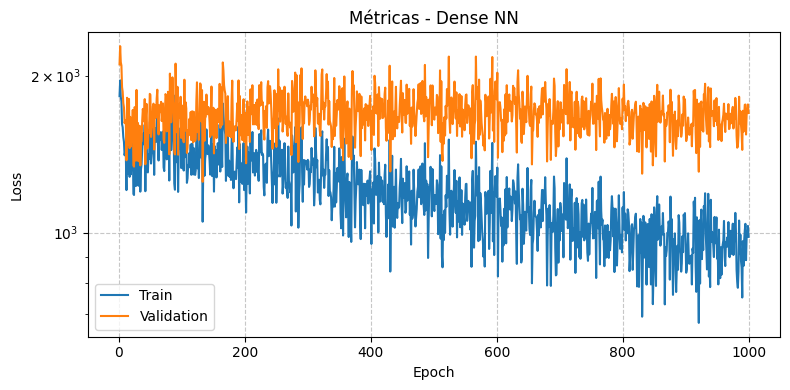

In [ ]:
# Definir optimizador
optimizer = torch.optim.RMSprop(dense_model.parameters(), lr=1e-4, weight_decay=1e-5)
# Cargar modelo si existe
model_path = os.path.join(MODELS, DENSE_MODEL['params'])
if os.path.exists(model_path):
    dense_model.load_state_dict(torch.load(model_path))
# Entrenar modelo
# Nota: si no desea entrenar el modelo, comentar la siguiente función
# y luego ejecutar la celda completa.
flag = False
if flag:
    dense_metrics = train_model(model=dense_model, 
                                train_loader=ts_dataset.train_loader, 
                                val_loader=ts_dataset.val_loader, 
                                optimizer=optimizer, 
                                num_epochs=1000, 
                                print_every=50,
                                loss=dense_metrics)
# Guardar métricas
with open(os.path.join(METRICS, DENSE_MODEL['metrics']), 'w') as f:
    json.dump(dense_metrics, f)
# Guardar modelo
torch.save(dense_model.state_dict(), os.path.join(MODELS, DENSE_MODEL['params']))
# Graficar pérdidas
plot_losses(history=dense_metrics, 
            title='Métricas - Dense NN', 
            save_path=os.path.join(FIGURES, DENSE_MODEL['plot_metrics']))

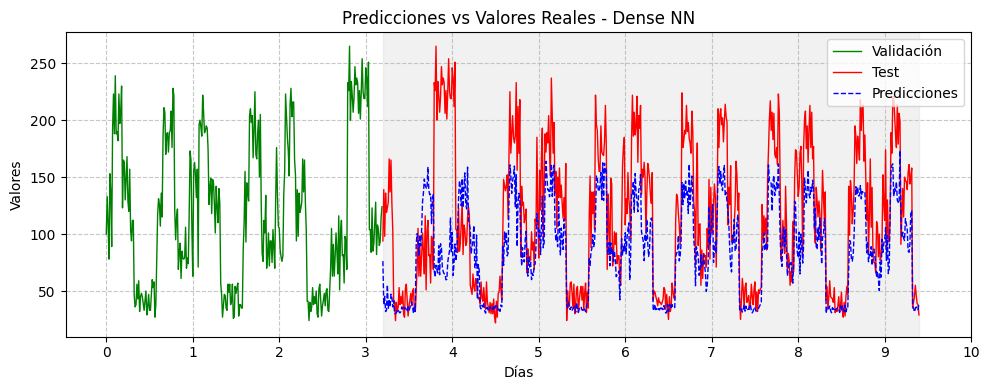

In [69]:
predictions = get_predictions(model=dense_model, test_loader=ts_dataset.test_loader)
plot_predictions(predictions=predictions, 
                 validation_data=ts_dataset.val_data, 
                 test_data=ts_dataset.test_data, 
                 samples_per_day=96, 
                 title='Predicciones vs Valores Reales - Dense NN', 
                 save_path=os.path.join(FIGURES, DENSE_MODEL['predictions']))

In [70]:
# Calcular MAPE usando sklearn
y_true = ts_dataset.test_data.reshape(-1)
y_pred = predictions.numpy().reshape(-1)
# Asegurar que y_true y y_pred tengan el mismo tamaño
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

mape_dense = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"MAPE: {mape_dense:.2f}%")

MAPE: 28.89%


### Modelo 2: Redes LSTM

#### Resultados del Entrenamiento
![Métricas de Entrenamiento](figures/lstm_metrics.png)

#### Predicciones
![Predicciones](figures/lstm_predictions.png)

In [22]:
LSTM_MODEL = {'params': "lstm_model.pth",
              'metrics': "lstm_metrics.json",
              'plot_metrics': "lstm_metrics.png",
              'predictions': "lstm_predictions.png"}

# Crear el modelo
input_size = 96
hidden_sizes = 96
output_size = 1
lstm_model = LSTM(input_size=input_size, 
                 hidden_size=hidden_sizes, 
                 num_layers=2, 
                 output_size=output_size, 
                 device=device)

In [23]:
# Eliminar metricas y modelo si existen
# Nota: Ejecutar solo si se desea entrenar el modelo desde cero
flag = False
if flag:
    if os.path.exists(os.path.join(METRICS, LSTM_MODEL['metrics'])):
        os.remove(os.path.join(METRICS, LSTM_MODEL['metrics']))
    if os.path.exists(os.path.join(MODELS, LSTM_MODEL['params'])):
        os.remove(os.path.join(MODELS, LSTM_MODEL['params']))

In [24]:
# Cargar métricas si existen, sino definirlas
metrics_path = os.path.join(METRICS, LSTM_MODEL['metrics'])
if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        lstm_metrics = json.load(f)
else:
    lstm_metrics = {'epochs': [], 'train': [], 'val': []}

Epoch 50/1000:Loss (Train/Val): 175.5492/612.1757
Epoch 100/1000:Loss (Train/Val): 177.7731/604.3923
Epoch 150/1000:Loss (Train/Val): 174.0773/609.7667
Epoch 200/1000:Loss (Train/Val): 169.6149/616.3299
Epoch 250/1000:Loss (Train/Val): 171.1341/616.3094
Epoch 300/1000:Loss (Train/Val): 170.4182/611.7258
Epoch 350/1000:Loss (Train/Val): 165.2946/613.6451
Epoch 400/1000:Loss (Train/Val): 164.5116/613.1773
Epoch 450/1000:Loss (Train/Val): 155.0423/614.1953
Epoch 500/1000:Loss (Train/Val): 153.5495/614.9462
Epoch 550/1000:Loss (Train/Val): 156.9377/619.6711
Epoch 600/1000:Loss (Train/Val): 155.4105/617.2372
Epoch 650/1000:Loss (Train/Val): 155.4299/626.9033
Epoch 700/1000:Loss (Train/Val): 147.6479/608.3980
Epoch 750/1000:Loss (Train/Val): 151.3237/614.1082
Epoch 800/1000:Loss (Train/Val): 142.6114/622.9011
Epoch 850/1000:Loss (Train/Val): 138.4290/624.9761
Epoch 900/1000:Loss (Train/Val): 139.8582/621.9333
Epoch 950/1000:Loss (Train/Val): 138.4938/620.1837
Epoch 1000/1000:Loss (Train/Val)

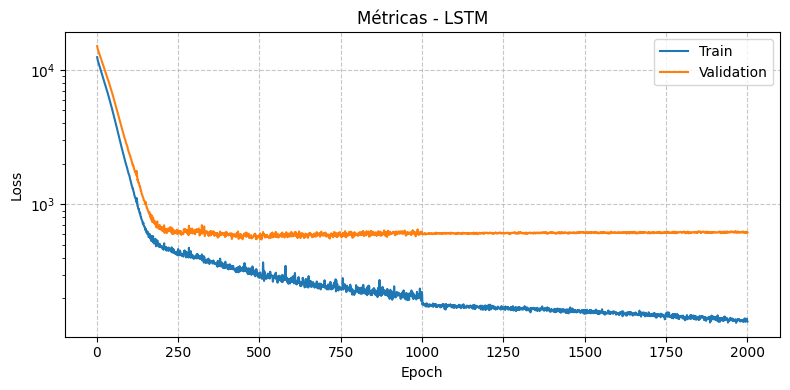

In [28]:
# Definir optimizador
optimizer = torch.optim.RMSprop(lstm_model.parameters(), lr=1e-5, weight_decay=1e-5)
# Cargar modelo si existe
model_path = os.path.join(MODELS, LSTM_MODEL['params'])
if os.path.exists(model_path):
    lstm_model.load_state_dict(torch.load(model_path))
# Entrenar modelo
# Nota: si no desea entrenar el modelo, comentar la siguiente función
# y luego ejecutar la celda completa.
lstm_metrics = train_model(model=lstm_model, 
                           train_loader=ts_dataset.train_loader, 
                           val_loader=ts_dataset.val_loader, 
                           optimizer=optimizer, 
                           num_epochs=1000, 
                           print_every=50,
                           loss=lstm_metrics)
# Guardar métricas
with open(os.path.join(METRICS, LSTM_MODEL['metrics']), 'w') as f:
    json.dump(lstm_metrics, f)
# Guardar modelo
torch.save(lstm_model.state_dict(), os.path.join(MODELS, LSTM_MODEL['params']))
# Graficar pérdidas
plot_losses(history=lstm_metrics, 
            title='Métricas - LSTM', 
            save_path=os.path.join(FIGURES, LSTM_MODEL['plot_metrics']))

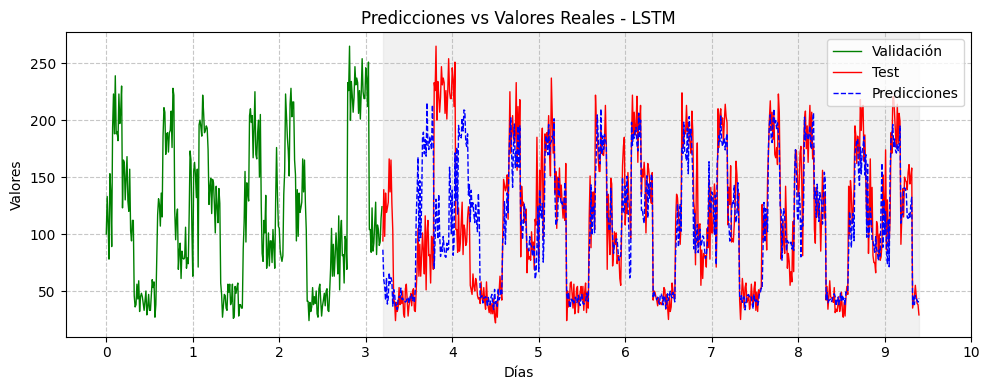

In [29]:
predictions = get_predictions(model=lstm_model, test_loader=ts_dataset.test_loader)
plot_predictions(predictions=predictions, 
                 validation_data=ts_dataset.val_data, 
                 test_data=ts_dataset.test_data, 
                 samples_per_day=96, 
                 title='Predicciones vs Valores Reales - LSTM', 
                 save_path=os.path.join(FIGURES, LSTM_MODEL['predictions']))

In [30]:
# Calcular MAPE usando sklearn
y_true = ts_dataset.test_data.reshape(-1)
y_pred = predictions.numpy().reshape(-1)
# Asegurar que y_true y y_pred tengan el mismo tamaño
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

mape_lstm = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"MAPE: {mape_lstm:.2f}%")

MAPE: 27.12%


### Modelo 3: Redes Convolucionales

#### Resultados del Entrenamiento
![Métricas de Entrenamiento](figures/cnn_metrics.png)

#### Predicciones
![Predicciones](figures/cnn_predictions.png)

In [12]:
CNN_MODEL = {'params': "cnn_model.pth",
              'metrics': "cnn_metrics.json",
              'plot_metrics': "cnn_metrics.png",
              'predictions': "cnn_predictions.png"}

# Crear el modelo
input_size = 96
output_size = 1
cnn_model = CNN1D(input_size=input_size, 
                  output_size=output_size,
                  device=device)

In [13]:
# Eliminar metricas y modelo si existen
# Nota: Ejecutar solo si se desea entrenar el modelo desde cero
if os.path.exists(os.path.join(METRICS, CNN_MODEL['metrics'])):
    os.remove(os.path.join(METRICS, CNN_MODEL['metrics']))
if os.path.exists(os.path.join(MODELS, CNN_MODEL['params'])):
    os.remove(os.path.join(MODELS, CNN_MODEL['params']))

In [14]:
# Cargar métricas si existen, sino definirlas
metrics_path = os.path.join(METRICS, CNN_MODEL['metrics'])
if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        cnn_metrics = json.load(f)
else:
    cnn_metrics = {'epochs': [], 'train': [], 'val': []}

Epoch 50/1000:Loss (Train/Val): 751.7164/1451.7482
Epoch 100/1000:Loss (Train/Val): 726.9835/1422.6369
Epoch 150/1000:Loss (Train/Val): 763.1443/1469.6163
Epoch 200/1000:Loss (Train/Val): 745.3327/1448.3346
Epoch 250/1000:Loss (Train/Val): 779.1699/1496.3133
Epoch 300/1000:Loss (Train/Val): 701.9488/1401.8081
Epoch 350/1000:Loss (Train/Val): 702.9910/1405.6286
Epoch 400/1000:Loss (Train/Val): 690.8495/1392.1781
Epoch 450/1000:Loss (Train/Val): 718.5499/1426.0584
Epoch 500/1000:Loss (Train/Val): 762.3578/1478.6098
Epoch 550/1000:Loss (Train/Val): 704.3752/1407.6540
Epoch 600/1000:Loss (Train/Val): 740.7064/1453.2095
Epoch 650/1000:Loss (Train/Val): 725.4996/1440.9454
Epoch 700/1000:Loss (Train/Val): 704.1980/1415.1781
Epoch 750/1000:Loss (Train/Val): 710.8404/1420.0878
Epoch 800/1000:Loss (Train/Val): 722.7403/1436.6900
Epoch 850/1000:Loss (Train/Val): 719.6045/1435.1212
Epoch 900/1000:Loss (Train/Val): 756.8276/1481.2237
Epoch 950/1000:Loss (Train/Val): 742.7331/1465.2416
Epoch 1000/10

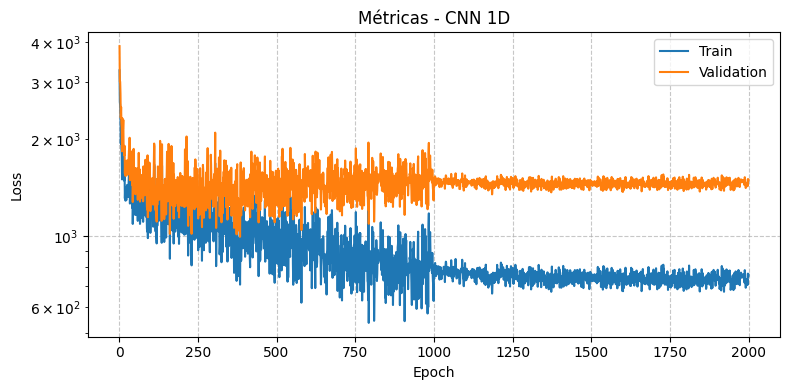

In [19]:
# Definir optimizador
optimizer = torch.optim.RMSprop(cnn_model.parameters(), lr=1e-5, weight_decay=1e-5)
# Cargar modelo si existe
model_path = os.path.join(MODELS, CNN_MODEL['params'])
if os.path.exists(model_path):
    cnn_model.load_state_dict(torch.load(model_path))
# Entrenar modelo
# Nota: si no desea entrenar el modelo, comentar la siguiente función
# y luego ejecutar la celda completa.
cnn_metrics = train_model(model=cnn_model, 
                          train_loader=ts_dataset.train_loader, 
                          val_loader=ts_dataset.val_loader, 
                          optimizer=optimizer, 
                          num_epochs=1000, 
                          print_every=50,
                          loss=cnn_metrics)
# Guardar métricas
with open(os.path.join(METRICS, CNN_MODEL['metrics']), 'w') as f:
    json.dump(cnn_metrics, f)
# Guardar modelo
torch.save(cnn_model.state_dict(), os.path.join(MODELS, CNN_MODEL['params']))
# Graficar pérdidas
plot_losses(history=cnn_metrics, 
            title='Métricas - CNN 1D', 
            save_path=os.path.join(FIGURES, CNN_MODEL['plot_metrics']))

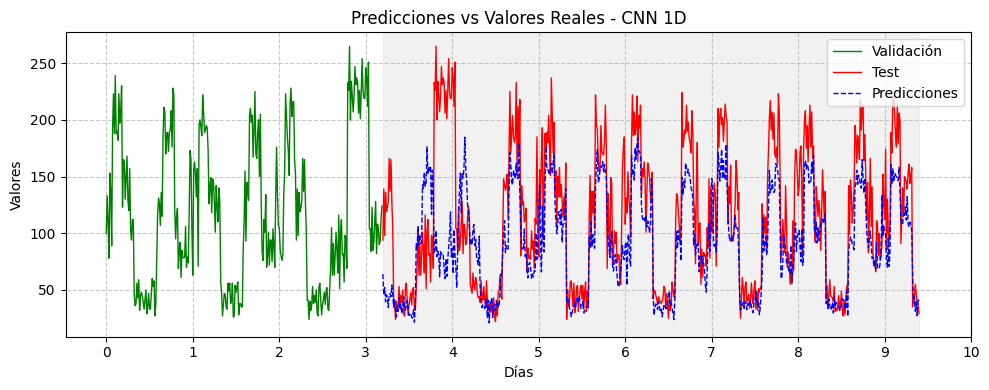

In [20]:
predictions = get_predictions(model=cnn_model, test_loader=ts_dataset.test_loader)
plot_predictions(predictions=predictions, 
                 validation_data=ts_dataset.val_data, 
                 test_data=ts_dataset.test_data, 
                 samples_per_day=96, 
                 title='Predicciones vs Valores Reales - CNN 1D', 
                 save_path=os.path.join(FIGURES, CNN_MODEL['predictions']))

In [21]:
# Calcular MAPE usando sklearn
y_true = ts_dataset.test_data.reshape(-1)
y_pred = predictions.numpy().reshape(-1)
# Asegurar que y_true y y_pred tengan el mismo tamaño
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

mape_cnn = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"MAPE: {mape_cnn:.2f}%")

MAPE: 28.11%


### Modelo 4: Redes Convolucionales + LSTM

#### Resultados del Entrenamiento
![Métricas de Entrenamiento](figures/cnn_lstm_metrics.png)

#### Predicciones
![Predicciones](figures/cnn_lstm_predictions.png)

In [31]:
CNN_LSTM_MODEL = {'params': "cnn_lstm_model.pth",
                  'metrics': "cnn_lstm_metrics.json",
                  'plot_metrics': "cnn_lstm_metrics.png",
                  'predictions': "cnn_lstm_predictions.png"}

# Crear el modelo
hidden_size = 96
output_size = 1
num_layers = 2
cnn_lstm_model = CNNLSTM(hidden_size=96, 
                         output_size=1, 
                         num_layers=2, 
                         device=device)

In [32]:
# Eliminar metricas y modelo si existen
# Nota: Ejecutar solo si se desea entrenar el modelo desde cero
if os.path.exists(os.path.join(METRICS, CNN_LSTM_MODEL['metrics'])):
    os.remove(os.path.join(METRICS, CNN_LSTM_MODEL['metrics']))
if os.path.exists(os.path.join(MODELS, CNN_LSTM_MODEL['params'])):
    os.remove(os.path.join(MODELS, CNN_LSTM_MODEL['params']))

In [33]:
# Cargar métricas si existen, sino definirlas
metrics_path = os.path.join(METRICS, CNN_LSTM_MODEL['metrics'])
if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        cnn_lstm_metrics = json.load(f)
else:
    cnn_lstm_metrics = {'epochs': [], 'train': [], 'val': []}

Epoch 50/500:Loss (Train/Val): 99.7597/672.2362
Epoch 100/500:Loss (Train/Val): 84.8059/641.0257
Epoch 150/500:Loss (Train/Val): 80.5808/660.2486
Epoch 200/500:Loss (Train/Val): 75.1736/658.2771
Epoch 250/500:Loss (Train/Val): 78.7114/633.2249
Epoch 300/500:Loss (Train/Val): 78.3000/669.3276
Epoch 350/500:Loss (Train/Val): 65.5984/659.2061
Epoch 400/500:Loss (Train/Val): 79.1644/660.8225
Epoch 450/500:Loss (Train/Val): 71.5119/671.5121
Epoch 500/500:Loss (Train/Val): 64.7470/645.5616


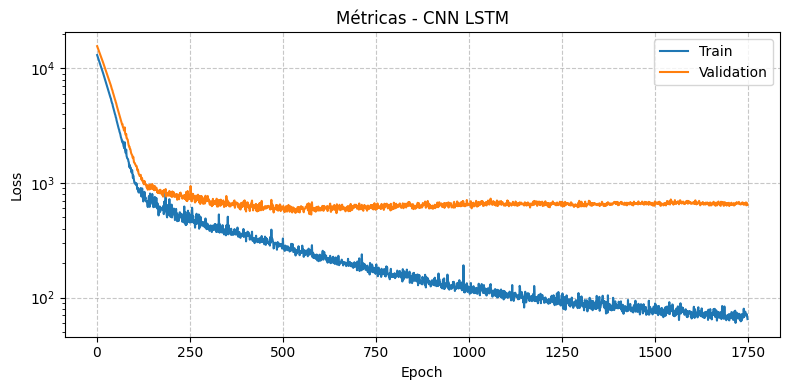

In [36]:
# Definir optimizador
optimizer = torch.optim.RMSprop(cnn_lstm_model.parameters(), lr=1e-4, weight_decay=1e-6)
# Cargar modelo si existe
model_path = os.path.join(MODELS, CNN_LSTM_MODEL['params'])
if os.path.exists(model_path):
    cnn_lstm_model.load_state_dict(torch.load(model_path))
# Entrenar modelo
# Nota: si no desea entrenar el modelo, comentar la siguiente función
# y luego ejecutar la celda completa.
cnn_lstm_metrics = train_model(model=cnn_lstm_model, 
                               train_loader=ts_dataset.train_loader, 
                               val_loader=ts_dataset.val_loader, 
                               optimizer=optimizer, 
                               num_epochs=500, 
                               print_every=50,
                               loss=cnn_lstm_metrics)
# Guardar métricas
with open(os.path.join(METRICS, CNN_LSTM_MODEL['metrics']), 'w') as f:
    json.dump(cnn_lstm_metrics, f)
# Guardar modelo
torch.save(cnn_lstm_model.state_dict(), os.path.join(MODELS, CNN_LSTM_MODEL['params']))
# Graficar pérdidas
plot_losses(history=cnn_lstm_metrics, 
            title='Métricas - CNN LSTM', 
            save_path=os.path.join(FIGURES, CNN_LSTM_MODEL['plot_metrics']))

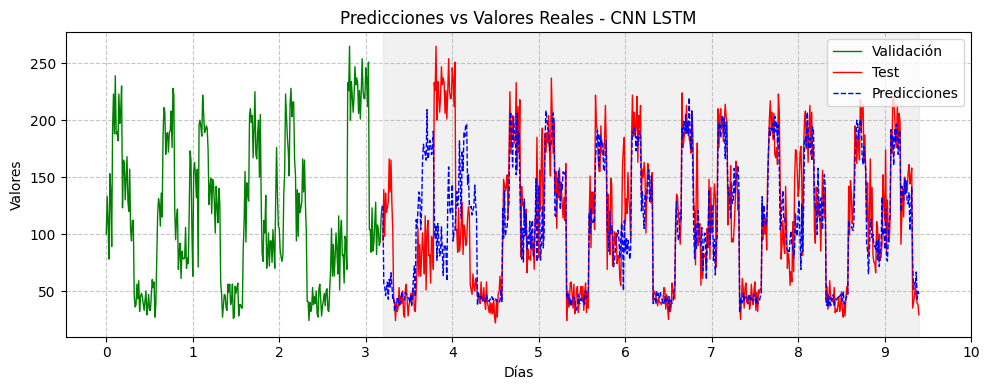

In [37]:
predictions = get_predictions(model=cnn_lstm_model, test_loader=ts_dataset.test_loader)
plot_predictions(predictions=predictions, 
                 validation_data=ts_dataset.val_data, 
                 test_data=ts_dataset.test_data, 
                 samples_per_day=96, 
                 title='Predicciones vs Valores Reales - CNN LSTM', 
                 save_path=os.path.join(FIGURES, CNN_LSTM_MODEL['predictions']))

In [38]:
# Calcular MAPE usando sklearn
y_true = ts_dataset.test_data.reshape(-1)
y_pred = predictions.numpy().reshape(-1)
# Asegurar que y_true y y_pred tengan el mismo tamaño
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

mape_cnn_lstm = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"MAPE: {mape_cnn_lstm:.2f}%")

MAPE: 27.26%


## Resumen Métricas

Para comparar el rendimiento de los cuatro modelos de redes neuronales (Dense, LSTM, CNN y CNN-LSTM) sobre el conjunto de test, se utiliza el MAPE (Mean Absolute Percentage Error) como métrica de evaluación. Esta métrica nos permite medir el error porcentual promedio entre las predicciones y los valores reales, facilitando la comparación directa entre los diferentes modelos.

![Métricas de prueba](figures/mape_comparison.png)

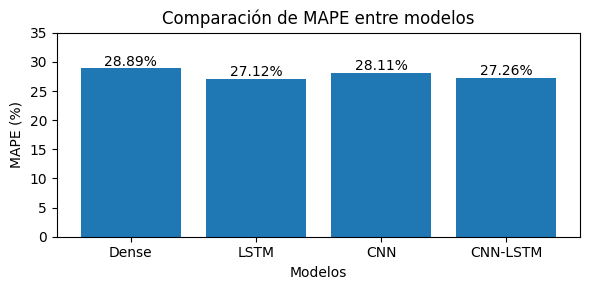

In [73]:
# Crear gráfico de barras comparativo de MAPE
plt.figure(figsize=(6, 3))
modelos = ['Dense', 'LSTM', 'CNN', 'CNN-LSTM']
mapes = [mape_dense, mape_lstm, mape_cnn, mape_cnn_lstm]

plt.bar(modelos, mapes)
plt.title('Comparación de MAPE entre modelos')
plt.xlabel('Modelos')
plt.ylabel('MAPE (%)')
plt.ylim(0, 35)

# Añadir valores sobre las barras
for i, v in enumerate(mapes):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES, 'mape_comparison.png'))
plt.show()

## Conclusiones

En este análisis, se implementaron y evaluaron cuatro arquitecturas diferentes de redes neuronales para la predicción de series temporales: Dense (red neuronal densa tradicional), LSTM (Long Short-Term Memory), CNN (Red Neuronal Convolucional) y una arquitectura híbrida CNN-LSTM.

Los resultados obtenidos muestran un rendimiento similar entre los cuatro modelos, con MAPEs que oscilan entre 27% y 29%. El modelo LSTM mostró el mejor rendimiento con 27.12%, seguido por el CNN-LSTM con 27.26%, mientras que el CNN y Dense tuvieron errores ligeramente mayores de 28.11% y 28.89% respectivamente. Este nivel de error sugiere que hay espacio para mejoras en el rendimiento de los modelos.

Algunas limitaciones y posibles áreas de mejora incluyen:

1. Configuración de ventanas: Se utilizó una ventana de entrada fija de 96 datos y una ventana de salida de 1 dato. Considerando la estacionalidad diaria observada (ciclos de 96 datos) y el patrón de la serie (períodos de cambios pequeños interrumpidos por cambios significativos), podría ser beneficioso:
   - Reducir la ventana de entrada
   - Aumentar la ventana de salida
   - Experimentar con diferentes combinaciones de ambas

2. Cantidad de datos: El conjunto de datos actual es relativamente pequeño (aproximadamente 6000 muestras en 2 meses). Un conjunto de datos más extenso podría permitir:
   - Mejor aprendizaje de patrones a largo plazo
   - Mayor capacidad de generalización
   - Mejor rendimiento general de los modelos

3. Estacionalidad: La serie temporal muestra una clara estacionalidad diaria que podría aprovecharse mejor mediante:
   - Técnicas de descomposición temporal
   - Características adicionales basadas en la periodicidad
   - Arquitecturas de red específicamente diseñadas para capturar patrones cíclicos

Estas observaciones sugieren que, si bien los modelos actuales proporcionan una base sólida, existe potencial para mejorar el rendimiento mediante ajustes en el preprocesamiento de datos, la arquitectura de los modelos y la ampliación del conjunto de datos de entrenamiento.
